In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets 
from scipy.signal import convolve as conv

# Exercise 1: Q-learning in a grid world

Grid worlds are simple environments where each state corresponds to a tile on a 2D grid, and the only actions the agent can take are to move up, down, left, or right across the grid tiles. The agent’s job is almost always to find a way to a goal tile in the most direct way possible while overcoming some maze or other obstacles, either static or dynamic.

We will explore Q-learning in a classic grid world: a cliff world environment. This is a 4x10 grid with a starting position in the lower-left (the S tile below) and the goal position in the lower-right. Every tile between these two is the “cliff”, and should the agent enter the cliff, they will receive a -100 reward and be sent back to the starting position. Every tile other than the cliff produces a -1 reward when entered. The goal tile (the E tile below) ends the episode after taking any action from it.

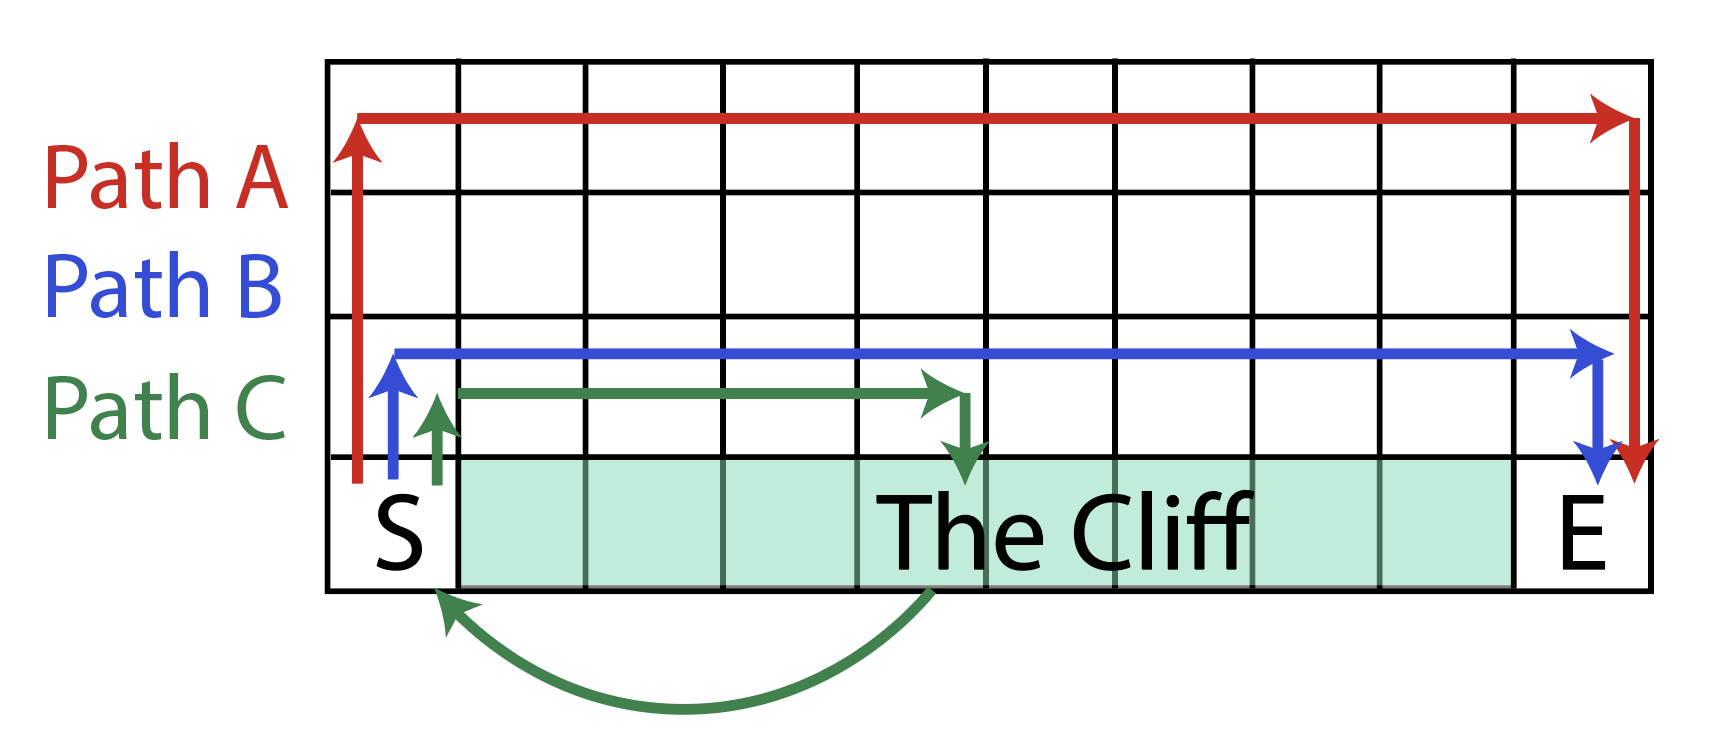

## A) Thinking through rewards

i) What is the total reward that a mouse taking path A would get?

ii) What is the total reward that a mouse taking path B would get?

iii) What is the total reward that a mouse taking path C then, once sent back to the start, path B would get?

iv) What path should the mouse learn to take?

Your answers here

## B) Epsilon-greedy policy

For our Q-learning mouse, we will use the epsilon-greedy strategy. At each step, the mouse will decide with probability $1 - \epsilon$ to use the best action for the state it is currently in by looking at the value function, otherwise just make a random choice.

See below for code that implements an epsilon-greedy policy. 

In [ ]:
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """

  be_greedy = np.random.random() > epsilon

  if be_greedy:
    
    # Choose best action 
    action = np.argmax(q)

  else:

    # Choose randomly 
    action = np.random.choice(len(q))

  return action


In the next cell, there is a demo where you can change the value of epsilon. We have 4 actions and the values of each action are [-2, 5, 0, 1].

**i) Does increasing epsilon increase the amount you explore or exploit?**

**ii) Describe in words what the mouse strategy is when epsilon = 0. Do the same when epsilon = 1.**

In [ ]:
#@markdown Make sure you execute this cell to enable the widget!

def plot_choices(q, epsilon, choice_fn, n_steps=1000, rng_seed=1):
  np.random.seed(rng_seed)
  counts = np.zeros_like(q)
  for t in range(n_steps):
    action = choice_fn(q, epsilon)
    counts[action] += 1

  fig, ax = plt.subplots()
  ax.bar(range(len(q)), counts/n_steps)
  ax.set(ylabel='% chosen', xlabel='action', ylim=(0,1), xticks=range(len(q)))

@widgets.interact(epsilon=widgets.FloatSlider(0.1, min=0.0, max=1.0))
def explore_epilson_values(epsilon=0.1):
  q = [-2, 5, 0, 1]
  plot_choices(q, epsilon, epsilon_greedy, rng_seed=None)


## C) Implementing Q-learning


Remember our Q-learning equation:

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

where $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $r$ is the reward, and $\gamma$ is the temporal discount rate.

In this exercise you will implement the Q-learning update rule described above. It takes in as arguments the previous state $s_t$, the action $a_t$ taken, the reward received $r_t$, the current state $s_{t+1}$, the Q-value table, the learning rate $\alpha$, and the discount factor $\gamma$. The method returns the updated Q-value table. 

Once we have our Q-learning algorithm, we will see how it handles learning to solve the Cliff World environment. 

Our environment is captured in the helper class `CliffWorld`. We will set `env = CliffWorld()`. We can then get the next state and reward by inputting the current state and action taken to `env.get_outcome(current_state, action)`.

 The process by which our the agent will interact with and learn about the environment is handled for you in the helper function `learn_environment`. This implements the entire learning episode lifecycle of stepping through the state observation, action selection (epsilon-greedy) and execution, reward, and state transition. This is hidden but I highly recommend checking it out to understand the flow of q-learning!
 
The key here is that we have an array `values`, which stores our q-values. This matrix is `n_states x n_actions`. So each row is a different state (one of the 40 possible states/tiles), and each column is a different action (up, left, right, down). This is what we want to update so we keep track of our state-action values.


In [ ]:
# @markdown Execute to get helper class `CliffWorld`

class CliffWorld:
  """
  World: Cliff world.
  40 states (4-by-10 grid world).
  The mapping from state to the grids are as follows:
  30 31 32 ... 39
  20 21 22 ... 29
  10 11 12 ... 19
  0  1  2  ...  9
  0 is the starting state (S) and 9 is the goal state (G).
  Actions 0, 1, 2, 3 correspond to right, up, left, down.
  Moving anywhere from state 9 (goal state) will end the session.
  Taking action down at state 11-18 will go back to state 0 and incur a
      reward of -100.
  Landing in any states other than the goal state will incur a reward of -1.
  Going towards the border when already at the border will stay in the same
      place.
  """
  def __init__(self):
    self.name = "cliff_world"
    self.n_states = 40
    self.n_actions = 4
    self.dim_x = 10
    self.dim_y = 4
    self.init_state = 0

  def get_outcome(self, state, action):
    if state == 9:  # goal state
      reward = 0
      next_state = None
      return next_state, reward
    reward = -1  # default reward value
    if action == 0:  # move right
      next_state = state + 1
      if state % 10 == 9:  # right border
        next_state = state
      elif state == 0:  # start state (next state is cliff)
        next_state = None
        reward = -100
    elif action == 1:  # move up
      next_state = state + 10
      if state >= 30:  # top border
        next_state = state
    elif action == 2:  # move left
      next_state = state - 1
      if state % 10 == 0:  # left border
        next_state = state
    elif action == 3:  # move down
      next_state = state - 10
      if state >= 11 and state <= 18:  # next is cliff
        next_state = None
        reward = -100
      elif state <= 9:  # bottom border
        next_state = state
    else:
      print("Action must be between 0 and 3.")
      next_state = None
      reward = None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state, reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, next_state, reward)]
    return outcomes


In [ ]:
# @markdown Execute to get helper plotting functions
def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')

def plot_heatmap_qs(env, values, cutoff = None):
  """
  Generate heatmap showing value per action per state
  """
  if cutoff is None:
      cutoff = values.min()

  fig, axes = plt.subplots(2, 2, figsize = (10, 7))
  axes = axes.flatten()
  actions = ['right', 'up', 'left', 'down']

  for a in range(4):
    value = values[:, a].reshape((env.dim_y,env.dim_x))
    value = value[::-1,:]

    ax = axes[a]
    im = ax.imshow(value, vmin = cutoff, vmax = values.max(), aspect='auto', interpolation='none', cmap = 'jet')
    ax.set(title=f'Value of moving {actions[a]}')
    ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
    ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
    if env.name != 'windy_cliff_grid':
        ax.set_yticklabels(
            ["%d" % y for y in np.arange(
                0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  fig.colorbar(im, ax=axes.ravel().tolist())
  
  return im
  
def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


# def plot_performance(env, value, reward_sums):
#   fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
#   plot_state_action_values(env, value, ax=axes[0,0])
#   plot_quiver_max_action(env, value, ax=axes[0,1])
#   plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
#   im = plot_heatmap_max_val(env, value, ax=axes[1,1])
#   fig.colorbar(im)

In [ ]:
# @markdown Execute to get helper funnction `learn_environment`

def learn_environment(env, learning_rule, epsilon, alpha, gamma, max_steps, n_episodes):
  
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  reward_sums = np.zeros(n_episodes)

  # Loop over episodes
  for episode in range(n_episodes):
    state = env.init_state  # initialize state
    reward_sum = 0

    # Loop over steps
    for t in range(max_steps):
      
      # choose next action
      action = epsilon_greedy(value[state], epsilon)

      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # update value function
      value = learning_rule(state, action, reward, next_state, value, gamma, alpha)

      # sum rewards obtained
      reward_sum += reward

      # End episode if mouse has reached final point
      if next_state is None:
          break  # episode ends

      # Update state
      state = next_state

    reward_sums[episode] = reward_sum

  return value, reward_sums

In [ ]:
def q_learning(state, action, reward, next_state, value, gamma, alpha):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    gamma (float): discount factor
    alpha (float): learning rate

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  
  # Q-value of current state-action pair
  q = value[state, action]

  # write an expression for finding the maximum Q-value at the next state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = ... # your code here! 

  # Write the expression to compute the TD error
  td_error = ... # your code here! 

  # Write the expression that updates the Q-value for the state-action pair
  value[state, action] = ... # your code here! 

  return value


# set for reproducibility
np.random.seed(1)

# parameters needed by our policy and learning rule
epsilon = 0.05  # epsilon-greedy policy
alpha = 0.1  # learning rate
gamma = 1  # discount factor

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
values, reward_sums_qlearning = learn_environment(env, q_learning, epsilon, alpha, gamma, max_steps, n_episodes)

# Plot total rewards over time
plot_rewards(n_episodes, reward_sums_qlearning)

Your plot should match the one below - if it does not, please fix before moving on as the next part depends on this.

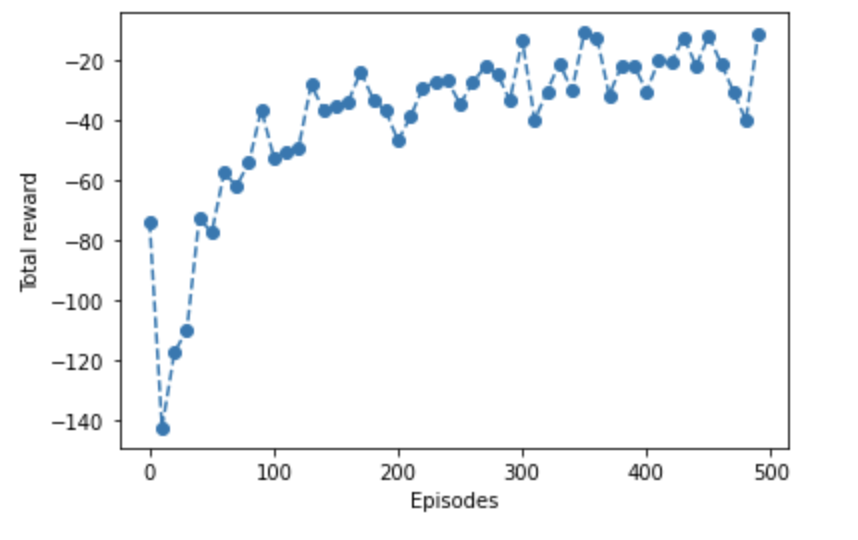

## D) Investigating what was learned

In the last plot, you should see that the mouse learned because the total reward increases over the episodes. Let's dive into what has been learned. Please write all your answers in one cell at the end to help us grade

**i) Based on the total reward values achieved by the last ten episodes (look at `reward_sums_qlearning[-10:]` below), has the mouse learned the best path? Explain how you know. Recall part A**

**ii) Why is the mouse still occasionally getting worse rewards on some trials?**



In [ ]:
# Print rewards of last 10 episodes
print(reward_sums_qlearning[-10:])


**iii) Below, we plot the q-values in each state per action (each action is a separate subplot). What state/action pairs are the most negative q-values associated with? Explain briefly why these state/action pairs should have negative q-values.**




In [ ]:
plot_heatmap_qs(env, values)

**iv) Below, we plot the action with the highest value per state. If the mouse is fully greedy, what path will it take? Is that the optimal path?**


In [ ]:
plot_quiver_max_action(env, values)

**v) What should the maximum q-value (across actions) for the state corresponding to red tile below? Why? Check if this was learned in `values` (this tile is row 16)**

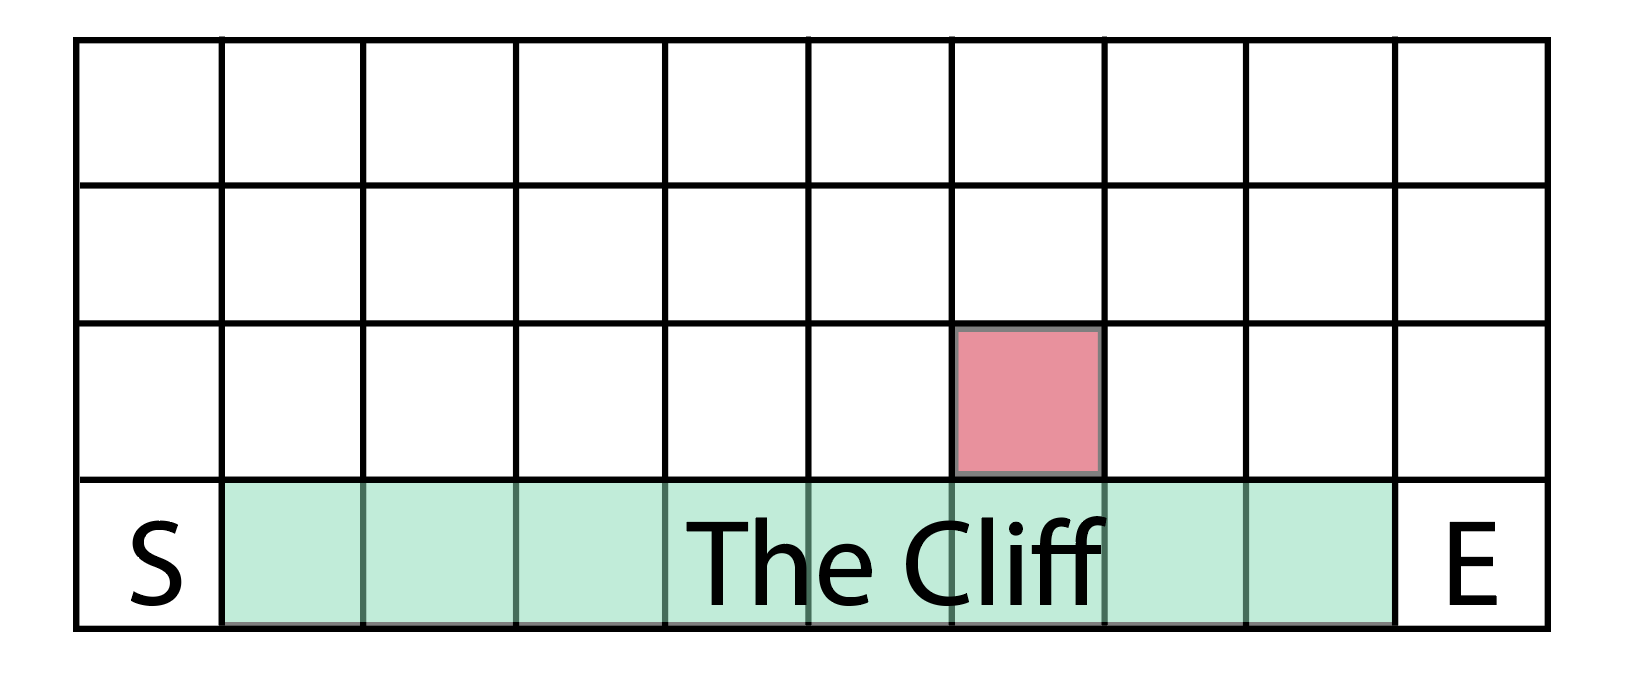

Your answers here

i)

ii)

iii)

iv)

v)

In [ ]:
# check values of red tile (row 16)


## E) Off vs on policy


Remember that SARSA is an on-policy algorithm with:
\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

The *only* difference between Q-learning and SARSA is the TD target calculation uses the policy to select the next action (in our case epsilon-greedy) rather than using the action that maximizes the Q-value.

**Below, I show the results of training SARSA on this same environment. Specifically, we show the action with the highest value per state. What is the path a greedy mouse will take? Is this different from the Q-learning and optimal solutions? If so, explain why this SARSA mouse may have learned this path based on the differences between SARSA and Q-learning. Focus on the state outlined as a red tile below to explain why the best action for this state differs between Q-learning and SARSA.**



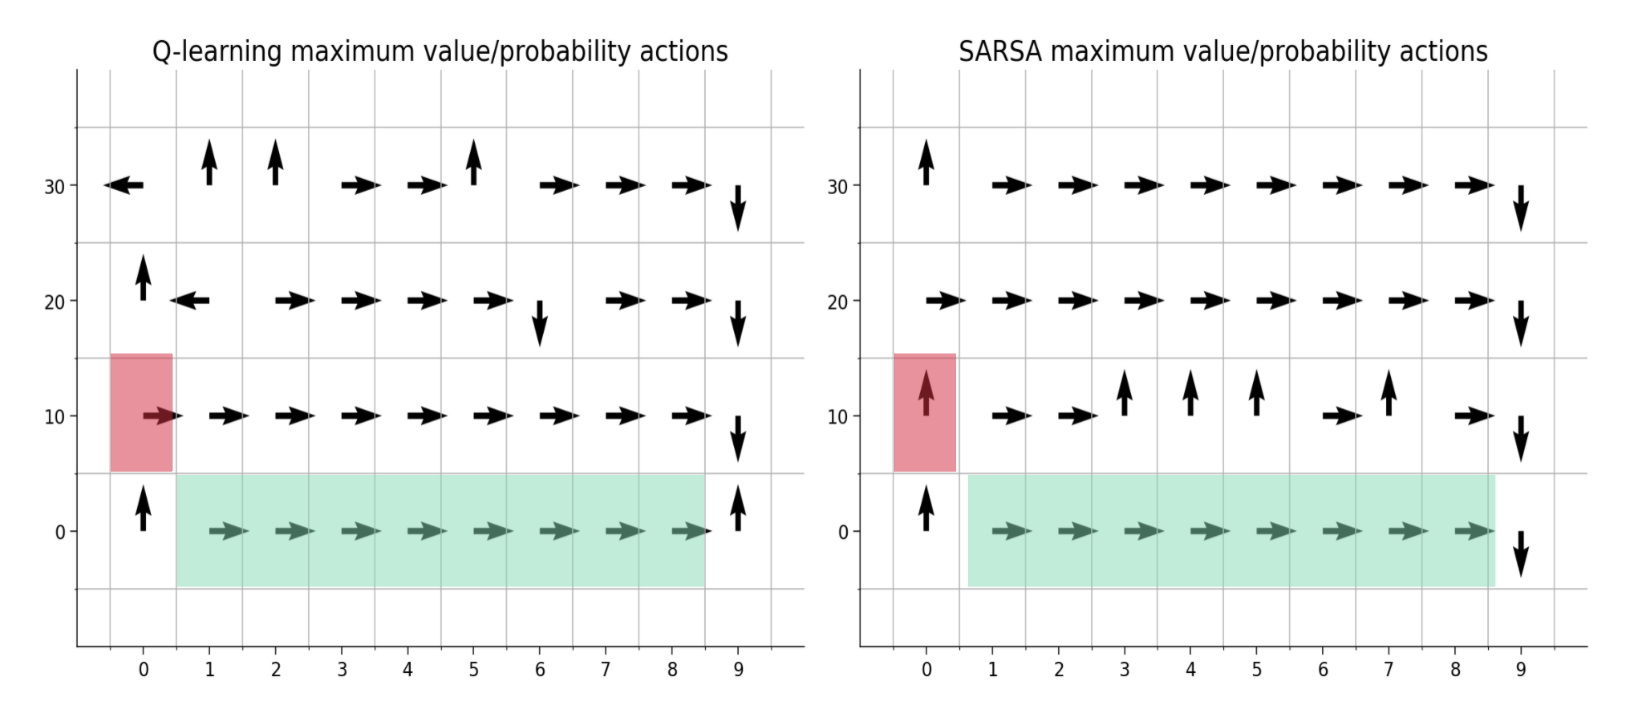

Your answers here